# Coherent Point Drift test 

** References: Myronenko _et al._, NIPS, 2006-2613 **



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


(208, 2)
(179, 2)
Data loaded successfully. 
45631.064595


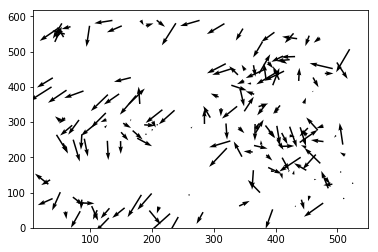

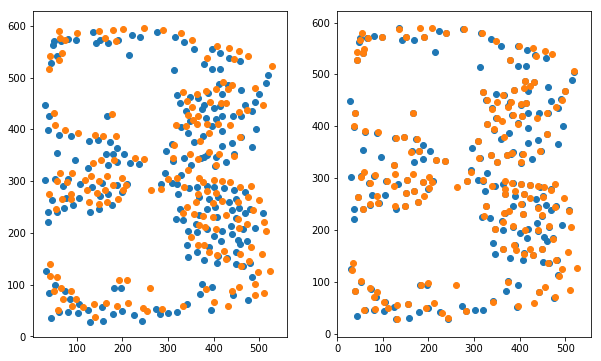

In [79]:
# This is the test cell.
test_data = np.load('cpd_test.npz')
X0 = test_data['X']
Y0 = test_data['Y']+np.array([10,10])
print(X0.shape)
print(Y0.shape)
cpd_test = CPD(X0, Y0, 1.5, 10.0, 1.0e-03)
Nit = 300
for nn in range(Nit):
    cpd_test.Estep()
    cpd_test.Mstep()
    
Y = cpd_test.Y
fig = cpd_test.display_velocity()

fig_comp = plt.figure(figsize =(10, 6))
ax1 = fig_comp.add_subplot(121)
ax2 = fig_comp.add_subplot(122)
ax1.scatter(X0[:,1], X0[:,0])
ax1.scatter(Y0[:,1], Y0[:,0])
ax2.scatter(X0[:,1], X0[:,0])
ax2.scatter(Y[:,1], Y[:,0])


In [61]:
# This is the Energy function
class CPD(object):
    '''
    coherent point drift class
    '''
    def __init__(self, X0, Y0, lambda_0, beta_0, omega_0 = 0.20):
        '''
        Initialization of the class
        '''
        self.Lam = lambda_0
        self.Beta = beta_0
        self.omg = omega_0
        if self.load_data(X0, Y0):
            diff_XY = diff_mat(X0, Y0)
            self.S2 = (diff_XY**2).sum()/(self.NX*self.NY*self.D)
            print(self.S2)
            self.W = np.zeros_like(self.Y)
            self.VT = np.zeros_like(self.Y)
        else:
            print("data loading failed.")
        
    def load_data(self, X0, Y0):
        '''
        Load the reference and deformed point sets.
        '''
        NX, DX = X0.shape
        NY, DY = Y0.shape
        if (DX == DY):
            print('Data loaded successfully. ')
            self.X = X0
            self.Y = Y0
            self.NX = NX
            self.NY = NY
            self.D = DX
            return True
        else:
            print('Data loading failed.')
            self.X = None
            self.Y = None
            return False
    
    
    def G_mat(self):
        '''
        construction of the G matrix
        '''
        diff_Y = diff_mat(self.Y)
        exp_core = (diff_Y**2).sum(axis = 0)/(2.*self.Beta*self.Beta)
        self.G = np.exp(-exp_core)
    
    def Estep(self):
        '''
        compute the probability matrix P_mn.
        '''
        self.G_mat()
        noise = self.omg/(1-self.omg) * np.sqrt((2*np.pi*self.S2)**self.D)*self.NY/self.NX # noise term
        
        diff_XY = diff_mat(self.X, self.Y+np.dot(self.G, self.W))
        exp_core = (diff_XY**2).sum(axis = 0)/(2*self.S2)# numerator
        numerator = np.exp(-exp_core)
        denominator = numerator.sum(axis = 0) # sum over Y 
        self.P = numerator/(denominator + noise)
        
    
    def Mstep(self):
        '''
        Solve the equation for W.
        '''
        DP = np.diag(self.P.sum(axis = 1))
        DPI = np.diag(1./self.P.sum(axis = 1)) # sum across X
        DPT = np.diag(self.P.sum(axis = 0)) # sum across Y
        LM = self.G + self.Lam*self.S2*DPI # both left and right are M x D matrices
        RM = np.dot(np.dot(DPI, self.P), self.X) - self.Y
        self.W = np.linalg.solve(LM, RM)
        self.V = np.dot(self.G, self.W) # updated Y
        TY = self.Y + self.V
        self.VT = self.VT + self.V
        NP = self.P.sum() 
        XPX  = np.dot(self.X.T, np.dot(DPT, self.X))
        PX = np.dot(self.P, self.X)
        TPT = np.dot(TY.T, np.dot(DP, TY))
        self.S2 = (np.trace(XPX) - 2*np.trace(np.dot(PX.T, TY)) + np.trace(TPT))/(NP*self.D)
        self.Y = TY
        
    def display_velocity(self):
        '''
        display the velocity field
        '''
        fig = plt.figure()
        ax = fig.add_subplot(111)
        xx = self.Y[:,1]
        yy = self.Y[:,0]
        uu = self.VT[:,1]
        vv = self.VT[:,0]
        ax.quiver(xx, yy, uu, vv)
        
        return fig
        
        

In [3]:
def diff_mat(X, Y=None):
    if Y is None:
        Y = X
    diff = []
    ND = X.shape[1]
    for dd in range(ND):
        XX, YY = np.meshgrid(X[:, dd], Y[:,dd])
        diff.append(XX-YY)
        
    diff = np.array(diff)
    return diff